# **Initial Load**

Authenticate with Google Drive and read in our dataset.

In [1]:
# Import any required libraries.
!pip install -U -q shap             # https://github.com/slundberg/shap
from patsy import dmatrices
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from statsmodels.api import add_constant
import statsmodels.discrete.discrete_model as sml
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
import folium
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import shap

In [2]:
!pip install -U -q PyDrive
# Dataset specific imports
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# Authenticate with Google Drive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Download our dataset from Google Drive.
downloaded_file = drive.CreateFile({ 'id': '14RMV7CRXwwCt_9iLHenyQrB9GC5gYwul' }) 
downloaded_file.GetContentFile('ChicagoCrimeRecords.csv')  
chicago_crime_records = pd.read_csv('ChicagoCrimeRecords.csv')


In [ ]:
chicago_crime_records = pd.read_csv('Chicago Crime Records.csv')

# Map Visualization

In [ ]:
chicago_crime_records

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7724488,12847575,JF420478,09/01/2022 05:00:00 AM,005XX W SURF ST,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,...,44.0,6.0,26,1172497.0,1919410.0,2022,01/03/2023 03:46:28 PM,41.934305,-87.641485,"(41.934304581, -87.641484982)"
7724489,12847801,JF420319,07/08/2022 12:00:00 AM,114XX S PRAIRIE AVE,1130,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,STREET,False,False,...,9.0,49.0,11,1179966.0,1828818.0,2022,01/03/2023 03:46:28 PM,41.685544,-87.616813,"(41.685543881, -87.616812541)"
7724490,12847324,JF420102,09/27/2022 11:00:00 AM,023XX E 70TH ST,0810,THEFT,OVER $500,RESIDENCE,False,False,...,5.0,43.0,06,1193181.0,1859005.0,2022,01/03/2023 03:46:28 PM,41.768068,-87.567453,"(41.768068052, -87.567452932)"
7724491,12847570,JF420427,09/03/2022 10:25:00 AM,052XX W CARMEN AVE,2021,NARCOTICS,POSSESS - BARBITURATES,RESIDENCE - YARD (FRONT / BACK),True,False,...,45.0,11.0,18,1140553.0,1933418.0,2022,01/03/2023 03:46:28 PM,41.973391,-87.758535,"(41.973391184, -87.758534512)"


In [ ]:
# Remove any columns that we are confident will not be of any use to our model.
#data with longitude and latitude
chicago_crime_records.drop(
    columns = ['Block', 'Case Number', 'Date', 'Description','FBI Code', 'ID', 'IUCR', 'Location', 'Updated On', 'X Coordinate', 'Y Coordinate', 'Year'],
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [ ]:
chicago_crime_records[chicago_crime_records['Latitude'].isna()]

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,WeekDay,WeekNumber,Month,Hour
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN,5,35,9,12
9,11645836,JC212333,05/01/2016 12:25:00 AM,055XX S ROCKWELL ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,NaN,2016,04/06/2019 04:04:43 PM,NaN,NaN,NaN,6,17,5,12
54,11645527,JC212744,02/02/2015 10:00:00 AM,069XX W ARCHER AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,OTHER,False,False,...,NaN,2015,04/06/2019 04:04:43 PM,NaN,NaN,NaN,0,05,2,10
84,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN,0,01,1,11
158,11645648,JC212959,01/01/2018 08:00:00 AM,024XX N MONITOR AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN,0,01,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7724468,12847574,JF420506,08/01/2021 09:00:00 AM,070XX W NEWPORT AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,NaN,2021,10/04/2022 04:52:49 PM,NaN,NaN,NaN,6,30,8,9
7724470,12847342,JF419999,11/01/2021 12:00:00 AM,090XX S THROOP ST,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,...,NaN,2021,10/04/2022 04:52:49 PM,NaN,NaN,NaN,0,44,11,12
7724473,12843644,JF414780,09/27/2022 05:00:00 PM,0000X E WASHINGTON ST,0870,THEFT,POCKET-PICKING,CTA TRAIN,False,False,...,NaN,2022,10/04/2022 04:52:49 PM,NaN,NaN,NaN,1,39,9,17
7724482,12847891,JF420656,09/30/2021 12:00:00 AM,087XX S PARNELL AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,NaN,2021,10/04/2022 04:52:49 PM,NaN,NaN,NaN,3,39,9,12


In [ ]:
#original code from
# https://www.fusebulbs.com/how-to-plot-coordinates-on-the-map-python/
#with the documenttation
# https://python-visualization.github.io/folium/modules.html

#we are passing Into Map location coodinates of Tughlakabad,new delhi which we found in avove codes.
#using geopy library
map=folium.Map(location=[28.518580000000043,77.27589000000006])
map.add_child(folium.Marker(location=[28.518580000000043,77.27589000000006],popup='Tughlakabad',icon=folium.Icon(color='green')))
map

In [ ]:
code =list(chicago_crime_records['Primary Type'].unique())
color_list=['red', 'blue', 'green', 'purple', 'orange', 'darkred','lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
print(code,len(code),color_list,len(color_list))
color_match={code[-i]:[color_list[i-1],10] for i in range(1,len(color_list))}
color_match

['BATTERY', 'THEFT', 'NARCOTICS', 'ASSAULT', 'BURGLARY', 'ROBBERY', 'OTHER OFFENSE', 'CRIMINAL DAMAGE', 'WEAPONS VIOLATION', 'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS', 'MOTOR VEHICLE THEFT', 'SEX OFFENSE', 'INTERFERENCE WITH PUBLIC OFFICER', 'OFFENSE INVOLVING CHILDREN', 'PUBLIC PEACE VIOLATION', 'PROSTITUTION', 'GAMBLING', 'CRIM SEXUAL ASSAULT', 'LIQUOR LAW VIOLATION', 'ARSON', 'STALKING', 'KIDNAPPING', 'INTIMIDATION', 'CONCEALED CARRY LICENSE VIOLATION', 'NON - CRIMINAL', 'HUMAN TRAFFICKING', 'OBSCENITY', 'CRIMINAL SEXUAL ASSAULT', 'PUBLIC INDECENCY', 'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL', 'HOMICIDE', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM'] 35 ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] 19


{'RITUALISM': ['red', 10],
 'NON-CRIMINAL (SUBJECT SPECIFIED)': ['blue', 10],
 'HOMICIDE': ['green', 10],
 'NON-CRIMINAL': ['purple', 10],
 'OTHER NARCOTIC VIOLATION': ['orange', 10],
 'PUBLIC INDECENCY': ['darkred', 10],
 'CRIMINAL SEXUAL ASSAULT': ['lightred', 10],
 'OBSCENITY': ['beige', 10],
 'HUMAN TRAFFICKING': ['darkblue', 10],
 'NON - CRIMINAL': ['darkgreen', 10],
 'CONCEALED CARRY LICENSE VIOLATION': ['cadetblue', 10],
 'INTIMIDATION': ['darkpurple', 10],
 'KIDNAPPING': ['white', 10],
 'STALKING': ['pink', 10],
 'ARSON': ['lightblue', 10],
 'LIQUOR LAW VIOLATION': ['lightgreen', 10],
 'CRIM SEXUAL ASSAULT': ['gray', 10],
 'GAMBLING': ['black', 10]}

In [ ]:
def getmap(color_match,chicago_crime_records=chicago_crime_records):
    mapp=folium.Map(location=[41.8781,-87.6298])

    for i in chicago_crime_records[['Longitude','Latitude','Primary Type']].values:
        if(i[2] in color_match):
            if(color_match[i[2]][1]>0):
                mapp.add_child(folium.Marker(location=[i[1],i[0]],popup=''+str(i)+str(color_match[i[2]][1]),icon=folium.Icon(color=color_match[i[2]][0])))
                color_match[i[2]][1]= color_match[i[2]][1]-1

        else:
            continue
    return mapp
    

In [ ]:

#getmap(color_match)
#getmap({code[7]:[color_list[2],60]})
#getmap({code[5]:[color_list[1],60]}).show_in_browser()

# **Data Analysis & Preparation**
Analyse and prepare our data before we attempt to train a predictive model using logistic regression.

In [ ]:
chicago_crime_records

In [3]:
# Drop any NANs before we begin.

chicago_crime_records.dropna(inplace = True)

In [4]:
# Feature Engineering
chicago_crime_records["WeekDay"] = chicago_crime_records.Date.map(lambda x: datetime(month=int(x[:2]),day=int(x[3:5]), year=int(x[6:10])).weekday())
chicago_crime_records["WeekNumber"] = chicago_crime_records.Date.map(lambda x: datetime(month=int(x[:2]),day=int(x[3:5]), year=int(x[6:10])).strftime("%W"))
chicago_crime_records["Month"] = chicago_crime_records.Date.map(lambda x: int(x[:2]))
chicago_crime_records["Hour"] = chicago_crime_records.Date.map(lambda x: int(x[11:13]) if x[-2:]=="AM" else int(x[11:13])+12)


In [ ]:
chicago_crime_records

In [8]:
code =list(chicago_crime_records['Primary Type'].unique())
for a in code:
    chicago_crime_records[a] = 0
    chicago_crime_records[a] = chicago_crime_records[a].astype(int)
    chicago_crime_records.loc[chicago_crime_records['Primary Type'] == a, a] = 1



KeyError: ignored

In [ ]:
Location_Description = list(chicago_crime_records['Location Description'].unique())
for a in Location_Description:
    chicago_crime_records[a] = 0
    chicago_crime_records[a] = chicago_crime_records[a].astype(int)
    chicago_crime_records.loc[chicago_crime_records['Location Description'] == a, a] = 1



DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [ ]:
aa=['Weekday_Monday','Weekday_Tuesday','Weekday_Wednessday',"Weekday_Thursday",'Weekday_Friday','Weekday_Saturday','Weekday_Sunday']
for a in range(7):
    chicago_crime_records[aa[a]] = 0
    chicago_crime_records[aa[a]] = chicago_crime_records[aa[a]].astype(int)
    chicago_crime_records.loc[chicago_crime_records['WeekDay'] == a, aa[a]] = 1


In [ ]:
# Take a look at all of the columns in our dataset.
list(chicago_crime_records.columns)

In [5]:
# Encode the 'Arrest', 'Domestic', 'Location Description' and 'Primary Type' columns.
chicago_crime_records['Arrest'] = chicago_crime_records['Arrest'].astype(int)
chicago_crime_records["WeekNumber"]=chicago_crime_records["WeekNumber"].astype(int)
chicago_crime_records['Domestic'] = chicago_crime_records['Domestic'].astype(int)

chicago_crime_records['Location Description'] = chicago_crime_records['Location Description'].astype('category')
chicago_crime_records['Location Description'] = chicago_crime_records['Location Description'].cat.codes


In [6]:
# Remove any columns that we are confident will not be of any use to our model.
chicago_crime_records.drop(
    columns = ['Block', 'Case Number','Primary Type','WeekDay', 'Date', 'Description','FBI Code', 'ID', 'IUCR', 'Latitude', 'Location', 'Longitude', 'Updated On', 'X Coordinate', 'Y Coordinate', 'Year'],
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [ ]:
# Remove any columns that we are confident will not be of any use to our model.
chicago_crime_records.drop(
    columns = ['Block', 'Case Number','Location Description', 'Date', 'Description','FBI Code', 'ID', 'IUCR', 'Latitude', 'Location', 'Longitude', 'Updated On', 'X Coordinate', 'Y Coordinate', 'Year'],
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [ ]:
list(chicago_crime_records.columns)

In [ ]:
code

In [ ]:
num=[]
for a in code :
    summ=sum(list(chicago_crime_records[a]))
    print('a',a,summ,sep=',')
    num.append(summ)
rrr={code[i]:num[i] for i in range(len(code))}
rrr

a,BATTERY,1294559
a,THEFT,1505819
a,NARCOTICS,678386
a,ASSAULT,462372
a,BURGLARY,390123
a,ROBBERY,267061
a,OTHER OFFENSE,440055
a,CRIMINAL DAMAGE,809080
a,WEAPONS VIOLATION,98874
a,DECEPTIVE PRACTICE,312974
a,CRIMINAL TRESPASS,195592
a,MOTOR VEHICLE THEFT,335825
a,SEX OFFENSE,27754
a,INTERFERENCE WITH PUBLIC OFFICER,17719
a,OFFENSE INVOLVING CHILDREN,52551
a,PUBLIC PEACE VIOLATION,48685
a,PROSTITUTION,61785
a,GAMBLING,13493
a,CRIM SEXUAL ASSAULT,25606
a,LIQUOR LAW VIOLATION,12838
a,CRIMINAL SEXUAL ASSAULT,6227
a,ARSON,11839
a,STALKING,4414
a,KIDNAPPING,6014
a,INTIMIDATION,4238
a,CONCEALED CARRY LICENSE VIOLATION,1031
a,NON - CRIMINAL,38
a,HUMAN TRAFFICKING,99
a,OBSCENITY,783
a,PUBLIC INDECENCY,181
a,OTHER NARCOTIC VIOLATION,138
a,NON-CRIMINAL,180
a,HOMICIDE,12041
a,NON-CRIMINAL (SUBJECT SPECIFIED),9
a,RITUALISM,16


In [ ]:
# Generate a correlation matrix, based on certain variables in our dataset.
correlation_matrix = chicago_crime_records[ [  'Arrest',
    'Beat',
    'Community Area',
    'District',
    'Domestic',
    'Ward']].corr()

correlation_matrix.style.background_gradient(cmap = 'coolwarm')

In [ ]:
# Calculate the V.I.F. for a collection of other variables in our dataset.
features = chicago_crime_records[['Arrest', 'Beat', 'Community Area', 'District', 'Domestic', 'Ward']]
vif_data = pd.DataFrame()
vif_data['Feature'] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]
print(vif_data)

          Feature        VIF
0          Arrest   1.317181
1            Beat  38.784899
2  Community Area   1.850315
3        District  42.167331
4        Domestic   1.165257
5            Ward   6.262408


In [7]:
# Based on the previous results, both 'Beat' and 'District' are contributing to multicollinearity.
# Consider dropping one or both of these variables to reduce inflation.
chicago_crime_records.drop(
    columns = ['Beat', 'District'],
    axis = 1,
    inplace = True,
    errors = 'ignore')

# **Model Construction/Training**
Train a collection of logistic regression models with varying sets of features.

In [ ]:
for i in chicago_crime_records:
    print(i)

In [ ]:
def getlogitSummary(code_column='BATTERY'):
    print(code_column,'\n\n')
    # Split up our training and testing sets.
    X = np.asarray(chicago_crime_records.drop(columns = code, axis = 1))
    y = np.asarray(chicago_crime_records[code_column])
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 78)
    
    # Train a logistic regression model.
    logit = sml.Logit(y_train, x_train).fit()
    print(logit.summary())
    
    confusion_matrix = pd.crosstab(y_test, np.round_(logit.predict(x_test), 0), rownames = ['Actual'], colnames = ['Predicted'])
    sns.heatmap(confusion_matrix, annot = True)
    
    # Calculate the Shapley additive explanations for our model.
    shap_values = shap.Explainer(
        logit.predict(x_test),
        x_train,
        feature_names = ['Location Description', 'Arrest', 'Domestic', 'Ward', 'Community Area'])
    
    print(shap_values)                                          
    report = classification_report(y_test, np.round_(logit.predict(x_test), 0))
    
    print(roc_auc_score(y_test,np.round_(logit.predict(x_test), 0)))
    print(report)
    return report

In [ ]:
def getlogitSummarySampling(code_column='BATTERY',resampler = None ):
    print(code_column,'\n\n')
    # Split up our training and testing sets.
    X = np.asarray(chicago_crime_records.drop(columns = code, axis = 1))
    y = np.asarray(chicago_crime_records[code_column])
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 78)
    if(resampler==None):
        resampler = RandomOverSampler()
    # Resample X and y so there are equal numbers of each y
    x_train_resampled, y_train_resampled = resampler.fit_resample(x_train,  y_train)

    # Train a logistic regression model.
    logit = sml.Logit(y_train_resampled, x_train_resampled).fit()
    print(logit.summary())
    
    confusion_matrix = pd.crosstab(y_test, np.round_(logit.predict(x_test), 0), rownames = ['Actual'], colnames = ['Predicted'])
    sns.heatmap(confusion_matrix, annot = True)
    #shap_values = shap.Explainer(logit).shap_values(x_train_resampled)
    #print(shap_values) 
    report = classification_report(y_test, np.round_(logit.predict(x_test), 0))
    print(roc_auc_score(y_test,np.round_(logit.predict(x_test), 0)))
    print(report)
    return report

In [ ]:
def getlogitSummarySampling2(code_column='BATTERY',resampler = None ,resampler2=None):
    print(code_column,'\n\n')
    # Split up our training and testing sets.
    X = np.asarray(chicago_crime_records.drop(columns = code, axis = 1))
    y = np.asarray(chicago_crime_records[code_column])
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 78)
    if(resampler==None):
        resampler = SMOTE(k_neighbors = 3)
    if(resampler2 ==None):
      resampler2 = RandomUnderSampler()
    # Resample X and y so there are equal numbers of each y
    x_train_resampled, y_train_resampled = resampler.fit_resample(x_train,  y_train)
    x_train_resampled, y_train_resampled = resampler2.fit_resample(x_train_resampled, y_train_resampled)

    # Train a logistic regression model.
    logit = sml.Logit(y_train_resampled, x_train_resampled).fit()
    print(logit.summary())
    
    confusion_matrix = pd.crosstab(y_test, np.round_(logit.predict(x_test), 0), rownames = ['Actual'], colnames = ['Predicted'])
    sns.heatmap(confusion_matrix, annot = True)
    #shap_values = shap.Explainer(logit).shap_values(x_train_resampled)
    #print(shap_values) 
    report = classification_report(y_test, np.round_(logit.predict(x_test), 0))
    print(roc_auc_score(y_test,np.round_(logit.predict(x_test), 0)))
    print(report)
    return logit,report

In [ ]:
ii=1
for i in chicago_crime_records.columns :
    
    if(i not in code):
      print('X'+str(ii),i,chicago_crime_records[i].dtype)
      ii=ii+1

In [ ]:

print([i for i in chicago_crime_records.columns if i not in code])

In [ ]:
chicago_crime_records.dtypes

In [ ]:
logit,output=getlogitSummarySampling2(code[1])
output

In [ ]:
# Calculate the Shapley additive explanations for our model.
X=np.asarray(chicago_crime_records.drop(columns = code, axis = 1))
feature_names = [i for i in chicago_crime_records.columns if i not in code]
n = 4000
training_data = shap.sample(X,n )
explainer = shap.LinearExplainer(logit.predict(training_data), training_data)
shap_values = explainer.shap_values(training_data, feature_names = feature_names,nsamples=100)
plt.plot()
shap.summary_plot(shap_values, 
                features = training_data, 
                feature_names = feature_names, 
                show=False,
                )
print(f"Sharp values for classifier :{name}")
plt.savefig(f"Shap {name}.png")
plt.show()

THEFT 


Optimization terminated successfully.
         Current function value: 0.472485
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              5621801
Model:                          Logit   Df Residuals:                  5621787
Method:                           MLE   Df Model:                           13
Date:                Mon, 03 Apr 2023   Pseudo R-squ.:                 0.08429
Time:                        16:11:39   Log-Likelihood:            -2.6562e+06
converged:                       True   LL-Null:                   -2.9007e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.3444      0.003   -426.534      0.000      -1.351      -1.338
x2            -2.044

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

           0       0.79      1.00      0.88   1107532
           1       0.00      0.00      0.00    297919

    accuracy                           0.79   1405451
   macro avg       0.39      0.50      0.44   1405451
weighted avg       0.62      0.79      0.69   1405451



'              precision    recall  f1-score   support\n\n           0       0.79      1.00      0.88   1107532\n           1       0.00      0.00      0.00    297919\n\n    accuracy                           0.79   1405451\n   macro avg       0.39      0.50      0.44   1405451\nweighted avg       0.62      0.79      0.69   1405451\n'

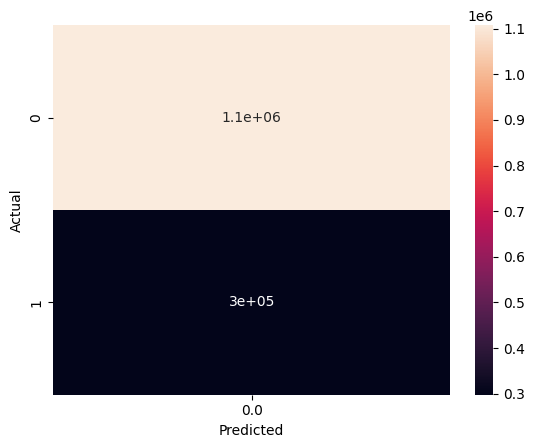

In [ ]:
getlogitSummary(code[1])

THEFT 


Optimization terminated successfully.
         Current function value: 0.624168
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              8865264
Model:                          Logit   Df Residuals:                  8865250
Method:                           MLE   Df Model:                           13
Date:                Mon, 03 Apr 2023   Pseudo R-squ.:                 0.09952
Time:                        16:47:22   Log-Likelihood:            -5.5334e+06
converged:                       True   LL-Null:                   -6.1449e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.3450      0.002   -711.480      0.000      -1.349      -1.341
x2            -2.041

'              precision    recall  f1-score   support\n\n           0       0.92      0.44      0.60   1107532\n           1       0.29      0.86      0.44    297919\n\n    accuracy                           0.53   1405451\n   macro avg       0.61      0.65      0.52   1405451\nweighted avg       0.79      0.53      0.56   1405451\n'

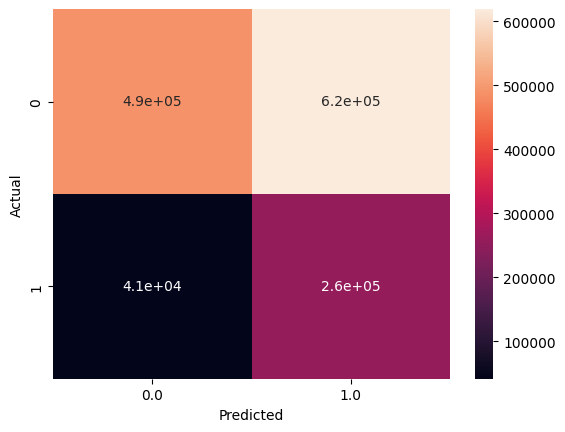

In [ ]:
getlogitSummarySampling(code[1],RandomOverSampler())

THEFT 


Optimization terminated successfully.
         Current function value: 0.624296
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              2378338
Model:                          Logit   Df Residuals:                  2378324
Method:                           MLE   Df Model:                           13
Date:                Mon, 03 Apr 2023   Pseudo R-squ.:                 0.09933
Time:                        16:47:48   Log-Likelihood:            -1.4848e+06
converged:                       True   LL-Null:                   -1.6485e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.3413      0.004   -367.708      0.000      -1.348      -1.334
x2            -2.037

'              precision    recall  f1-score   support\n\n           0       0.92      0.44      0.60   1107532\n           1       0.29      0.86      0.44    297919\n\n    accuracy                           0.53   1405451\n   macro avg       0.61      0.65      0.52   1405451\nweighted avg       0.79      0.53      0.56   1405451\n'

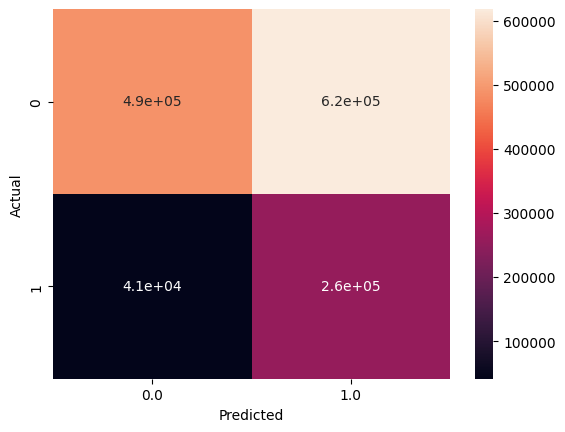

In [ ]:
getlogitSummarySampling(code[1],RandomUnderSampler())

THEFT 


Optimization terminated successfully.
         Current function value: 0.610906
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              8865264
Model:                          Logit   Df Residuals:                  8865250
Method:                           MLE   Df Model:                           13
Date:                Mon, 03 Apr 2023   Pseudo R-squ.:                  0.1186
Time:                        16:51:12   Log-Likelihood:            -5.4158e+06
converged:                       True   LL-Null:                   -6.1449e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.5819      0.002   -779.304      0.000      -1.586      -1.578
x2            -2.400

'              precision    recall  f1-score   support\n\n           0       0.92      0.44      0.59   1107532\n           1       0.29      0.86      0.44    297919\n\n    accuracy                           0.53   1405451\n   macro avg       0.61      0.65      0.52   1405451\nweighted avg       0.79      0.53      0.56   1405451\n'

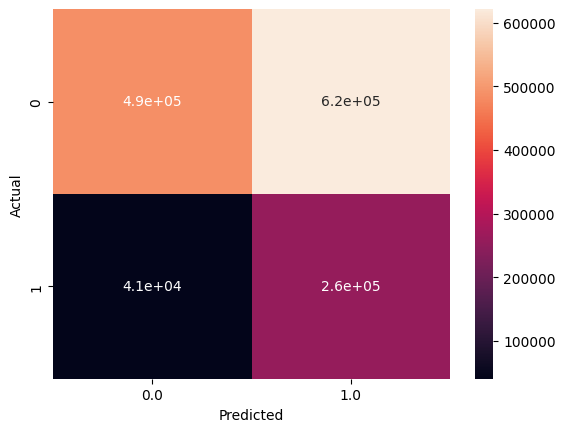

In [ ]:
getlogitSummarySampling(code[1],SMOTE(k_neighbors = 3))

In [ ]:
output =[]
code.append('Primary Type')
for c in code:
    try:
        summaryy=getlogitSummary(c)
    except:
        pass
    output.append('a:'+':'.join([':'.join([a for a in b.replace(' ',',').split(',') if a ]) for b in summaryy.split('\n')[2:4]]))
print(output)

BATTERY 




NameError: name 'summaryy' is not defined

In [ ]:
output

['a:0:0.86:0.95:0.90:1160523:1:0.58:0.33:0.42:259157', 'a:0:0.79:1.00:0.88:1118667:1:0.00:0.00:0.00:301013', 'a:0:0.92:0.96:0.94:1284013:1:0.35:0.22:0.27:135667', 'a:0:0.93:1.00:0.97:1327064:1:0.00:0.00:0.00:92616', 'a:0:0.95:1.00:0.97:1341958:1:0.00:0.00:0.00:77722', 'a:0:0.96:1.00:0.98:1366115:1:0.00:0.00:0.00:53565', 'a:0:0.94:1.00:0.97:1331856:1:0.20:0.00:0.00:87824', 'a:0:0.89:1.00:0.94:1257727:1:0.00:0.00:0.00:161953', 'a:0:0.99:1.00:0.99:1399927:1:0.01:0.00:0.00:19753', 'a:0:0.96:1.00:0.98:1356954:1:0.00:0.00:0.00:62726', 'a:0:0.97:1.00:0.99:1380443:1:0.25:0.01:0.02:39237', 'a:0:0.95:1.00:0.98:1352739:1:0.00:0.00:0.00:66941', 'a:0:1.00:1.00:1.00:1414132:1:0.00:0.00:0.00:5548', 'a:0:1.00:1.00:1.00:1416179:1:0.00:0.00:0.00:3501', 'a:0:0.99:1.00:1.00:1409244:1:0.02:0.00:0.00:10436', 'a:0:0.99:1.00:1.00:1409959:1:0.00:0.00:0.00:9721', 'a:0:0.99:1.00:1.00:1407149:1:0.02:0.00:0.00:12531', 'a:0:1.00:1.00:1.00:1416999:1:0.01:0.00:0.00:2681', 'a:0:1.00:1.00:1.00:1414546:1:0.00:0.00:0.00:

BATTERY 


Optimization terminated successfully.
         Current function value: 0.594198
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              9286634
Model:                          Logit   Df Residuals:                  9286629
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Mar 2023   Pseudo R-squ.:                  0.1428
Time:                        11:14:10   Log-Likelihood:            -5.5181e+06
converged:                       True   LL-Null:                   -6.4370e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0012      1e-05   -123.103      0.000      -0.001      -0.001
x2            -0.2

              precision    recall  f1-score   support

           0       0.98      0.64      0.77   1341958
           1       0.11      0.75      0.19     77722

    accuracy                           0.64   1419680
   macro avg       0.54      0.70      0.48   1419680
weighted avg       0.93      0.64      0.74   1419680

ROBBERY 


Optimization terminated successfully.
         Current function value: 0.624400
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:             10930446
Model:                          Logit   Df Residuals:                 10930441
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Mar 2023   Pseudo R-squ.:                 0.09918
Time:                        11:20:05   Log-Likelihood:            -6.8250e+06
converged:                       True   LL-Null:                   -7.5764e+06
Covaria

              precision    recall  f1-score   support

           0       0.98      0.58      0.73   1356954
           1       0.07      0.70      0.13     62726

    accuracy                           0.59   1419680
   macro avg       0.52      0.64      0.43   1419680
weighted avg       0.94      0.59      0.70   1419680

CRIMINAL TRESPASS 


Optimization terminated successfully.
         Current function value: 0.559981
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:             11044728
Model:                          Logit   Df Residuals:                 11044723
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Mar 2023   Pseudo R-squ.:                  0.1921
Time:                        11:23:23   Log-Likelihood:            -6.1848e+06
converged:                       True   LL-Null:                   -7.6556e+

              precision    recall  f1-score   support

           0       1.00      0.85      0.92   1409244
           1       0.03      0.55      0.05     10436

    accuracy                           0.85   1419680
   macro avg       0.51      0.70      0.48   1419680
weighted avg       0.99      0.85      0.91   1419680

PUBLIC PEACE VIOLATION 


Optimization terminated successfully.
         Current function value: 0.606568
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:             11279510
Model:                          Logit   Df Residuals:                 11279505
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Mar 2023   Pseudo R-squ.:                  0.1249
Time:                        11:25:53   Log-Likelihood:            -6.8418e+06
converged:                       True   LL-Null:                   -7.8

              precision    recall  f1-score   support

           0       1.00      0.77      0.87   1417159
           1       0.01      0.97      0.01      2521

    accuracy                           0.77   1419680
   macro avg       0.50      0.87      0.44   1419680
weighted avg       1.00      0.77      0.87   1419680

CRIMINAL SEXUAL ASSAULT 


Optimization terminated successfully.
         Current function value: 0.618676
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:             11347444
Model:                          Logit   Df Residuals:                 11347439
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Mar 2023   Pseudo R-squ.:                  0.1074
Time:                        11:28:18   Log-Likelihood:            -7.0204e+06
converged:                       True   LL-Null:                   -7.

              precision    recall  f1-score   support

           0       1.00      0.37      0.54   1418808
           1       0.00      0.75      0.00       872

    accuracy                           0.37   1419680
   macro avg       0.50      0.56      0.27   1419680
weighted avg       1.00      0.37      0.54   1419680

CONCEALED CARRY LICENSE VIOLATION 


Optimization terminated successfully.
         Current function value: 0.363508
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:             11355898
Model:                          Logit   Df Residuals:                 11355893
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Mar 2023   Pseudo R-squ.:                  0.4756
Time:                        11:30:16   Log-Likelihood:            -4.1280e+06
converged:                       True   LL-Null:           

E:\Programinglanguages\Python\Python3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:             11357376
Model:                          Logit   Df Residuals:                 11357371
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Mar 2023   Pseudo R-squ.:                  0.1006
Time:                        11:31:17   Log-Likelihood:            -7.0805e+06
converged:                      False   LL-Null:                   -7.8723e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0019   1.11e-05    172.003      0.000       0.002       0.002
x2            -0.6186      0.002   -367.857      0.000      -0.622      -0.615
x3            -8.1611      0.059   -137.326      0.0

E:\Programinglanguages\Python\Python3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:             11357154
Model:                          Logit   Df Residuals:                 11357149
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Mar 2023   Pseudo R-squ.:                  0.5292
Time:                        11:33:04   Log-Likelihood:            -3.7063e+06
converged:                      False   LL-Null:                   -7.8722e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0123   1.75e-05   -701.334      0.000      -0.012      -0.012
x2             4.9566      0.003   1615.257      0.000       4.951       4.963
x3           -30.7694   3650.843     -0.008      0.9

              precision    recall  f1-score   support

           0       1.00      0.80      0.89   1419678
           1       0.00      1.00      0.00         2

    accuracy                           0.80   1419680
   macro avg       0.50      0.90      0.45   1419680
weighted avg       1.00      0.80      0.89   1419680

RITUALISM 


Optimization terminated successfully.
         Current function value: 0.636442
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:             11357412
Model:                          Logit   Df Residuals:                 11357407
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Mar 2023   Pseudo R-squ.:                 0.08181
Time:                        11:35:04   Log-Likelihood:            -7.2283e+06
converged:                       True   LL-Null:                   -7.8724e+06
Covar

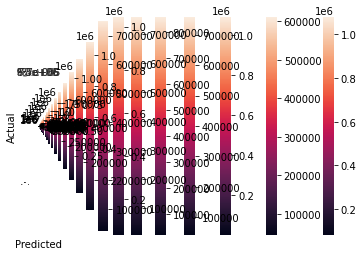

In [ ]:
#OverSampling
output =[]
code.append('Primary Type')
# Synthesise new examples using SMOTE and undersampling.
oversampler = SMOTE(k_neighbors = 3)
for c in code:
    try:
        summaryy=getlogitSummarySampling(c,oversampler)
    except Exception as e:
        print(e)
    output.append('a:'+':'.join([':'.join([a for a in b.replace(' ',',').split(',') if a ]) for b in summaryy.split('\n')[2:4]]))
print(output)

In [ ]:
output

['a:0:0.88:0.93:0.90:1160523:1:0.58:0.44:0.50:259157',
 'a:0:0.92:0.45:0.61:1118667:1:0.30:0.85:0.44:301013',
 'a:0:1.00:0.85:0.92:1284013:1:0.41:0.98:0.58:135667',
 'a:0:0.95:0.57:0.71:1327064:1:0.08:0.55:0.14:92616',
 'a:0:0.98:0.64:0.77:1341958:1:0.11:0.75:0.19:77722',
 'a:0:0.99:0.45:0.61:1366115:1:0.06:0.83:0.10:53565',
 'a:0:0.95:0.78:0.86:1331856:1:0.11:0.40:0.17:87824',
 'a:0:0.96:0.40:0.57:1257727:1:0.16:0.86:0.26:161953',
 'a:0:1.00:0.77:0.87:1399927:1:0.04:0.74:0.08:19753',
 'a:0:0.98:0.58:0.73:1356954:1:0.07:0.70:0.13:62726',
 'a:0:0.99:0.77:0.86:1380443:1:0.08:0.69:0.14:39237',
 'a:0:0.99:0.54:0.70:1352739:1:0.08:0.86:0.15:66941',
 'a:0:1.00:0.63:0.77:1414132:1:0.00:0.46:0.01:5548',
 'a:0:1.00:0.77:0.87:1416179:1:0.01:0.91:0.02:3501',
 'a:0:1.00:0.85:0.92:1409244:1:0.03:0.55:0.05:10436',
 'a:0:1.00:0.76:0.87:1409959:1:0.02:0.63:0.04:9721',
 'a:0:1.00:0.78:0.88:1407149:1:0.04:0.99:0.07:12531',
 'a:0:1.00:0.77:0.87:1416999:1:0.01:0.98:0.02:2681',
 'a:0:1.00:0.67:0.80:1414546

In [ ]:
#old output 
output

['a:0:0.88:0.93:0.90:1160523:1:0.58:0.44:0.50:259157', 'a:0:0.92:0.45:0.61:1118667:1:0.30:0.85:0.44:301013', 'a:0:1.00:0.85:0.92:1284013:1:0.41:0.98:0.58:135667', 'a:0:0.95:0.58:0.72:1327064:1:0.08:0.54:0.14:92616', 'a:0:0.98:0.64:0.77:1341958:1:0.11:0.74:0.19:77722', 'a:0:0.99:0.45:0.62:1366115:1:0.06:0.83:0.10:53565', 'a:0:0.95:0.79:0.86:1331856:1:0.11:0.40:0.17:87824', 'a:0:0.96:0.40:0.57:1257727:1:0.16:0.86:0.26:161953', 'a:0:1.00:0.77:0.87:1399927:1:0.04:0.74:0.08:19753', 'a:0:0.98:0.58:0.73:1356954:1:0.07:0.70:0.13:62726', 'a:0:0.99:0.77:0.86:1380443:1:0.08:0.69:0.14:39237', 'a:0:0.99:0.54:0.70:1352739:1:0.08:0.86:0.15:66941', 'a:0:1.00:0.63:0.77:1414132:1:0.00:0.46:0.01:5548', 'a:0:1.00:0.77:0.87:1416179:1:0.01:0.91:0.02:3501', 'a:0:1.00:0.85:0.92:1409244:1:0.03:0.56:0.05:10436', 'a:0:1.00:0.76:0.86:1409959:1:0.02:0.63:0.03:9721', 'a:0:1.00:0.78:0.88:1407149:1:0.04:0.99:0.07:12531', 'a:0:1.00:0.77:0.87:1416999:1:0.01:0.98:0.02:2681', 'a:0:1.00:0.68:0.81:1414546:1:0.01:0.51:0.01:

BATTERY 


Optimization terminated successfully.
         Current function value: 0.593952
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              2070804
Model:                          Logit   Df Residuals:                  2070799
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Mar 2023   Pseudo R-squ.:                  0.1431
Time:                        08:16:54   Log-Likelihood:            -1.2300e+06
converged:                       True   LL-Null:                   -1.4354e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0013   2.13e-05    -58.912      0.000      -0.001      -0.001
x2            -0.2

              precision    recall  f1-score   support

           0       0.98      0.64      0.77   1341958
           1       0.11      0.74      0.19     77722

    accuracy                           0.65   1419680
   macro avg       0.54      0.69      0.48   1419680
weighted avg       0.93      0.65      0.74   1419680

ROBBERY 


Optimization terminated successfully.
         Current function value: 0.628079
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               426992
Model:                          Logit   Df Residuals:                   426987
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Mar 2023   Pseudo R-squ.:                 0.09387
Time:                        08:17:30   Log-Likelihood:            -2.6818e+05
converged:                       True   LL-Null:                   -2.9597e+05
Covaria

              precision    recall  f1-score   support

           0       0.98      0.58      0.73   1356954
           1       0.07      0.70      0.13     62726

    accuracy                           0.59   1419680
   macro avg       0.52      0.64      0.43   1419680
weighted avg       0.94      0.59      0.70   1419680

CRIMINAL TRESPASS 


Optimization terminated successfully.
         Current function value: 0.564137
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               312710
Model:                          Logit   Df Residuals:                   312705
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Mar 2023   Pseudo R-squ.:                  0.1861
Time:                        08:18:00   Log-Likelihood:            -1.7641e+05
converged:                       True   LL-Null:                   -2.1675e+

              precision    recall  f1-score   support

           0       1.00      0.83      0.91   1409244
           1       0.02      0.58      0.05     10436

    accuracy                           0.83   1419680
   macro avg       0.51      0.70      0.48   1419680
weighted avg       0.99      0.83      0.90   1419680

PUBLIC PEACE VIOLATION 


Optimization terminated successfully.
         Current function value: 0.607462
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                77928
Model:                          Logit   Df Residuals:                    77923
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Mar 2023   Pseudo R-squ.:                  0.1236
Time:                        08:18:27   Log-Likelihood:                -47338.
converged:                       True   LL-Null:                       

              precision    recall  f1-score   support

           0       1.00      0.77      0.87   1417159
           1       0.01      0.97      0.01      2521

    accuracy                           0.77   1419680
   macro avg       0.50      0.87      0.44   1419680
weighted avg       1.00      0.77      0.87   1419680

CRIMINAL SEXUAL ASSAULT 


Optimization terminated successfully.
         Current function value: 0.629425
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 9994
Model:                          Logit   Df Residuals:                     9989
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Mar 2023   Pseudo R-squ.:                 0.09193
Time:                        08:18:53   Log-Likelihood:                -6290.5
converged:                       True   LL-Null:                      

              precision    recall  f1-score   support

           0       1.00      0.30      0.46   1418808
           1       0.00      0.83      0.00       872

    accuracy                           0.30   1419680
   macro avg       0.50      0.57      0.23   1419680
weighted avg       1.00      0.30      0.46   1419680

CONCEALED CARRY LICENSE VIOLATION 


Optimization terminated successfully.
         Current function value: 0.398073
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1540
Model:                          Logit   Df Residuals:                     1535
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Mar 2023   Pseudo R-squ.:                  0.4257
Time:                        08:19:19   Log-Likelihood:                -613.03
converged:                       True   LL-Null:            

E:\Programinglanguages\Python\Python3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


              precision    recall  f1-score   support

           0       1.00      0.51      0.68   1419673
           1       0.00      0.71      0.00         7

    accuracy                           0.51   1419680
   macro avg       0.50      0.61      0.34   1419680
weighted avg       1.00      0.51      0.68   1419680

HUMAN TRAFFICKING 


Optimization terminated successfully.
         Current function value: 0.664434
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  158
Model:                          Logit   Df Residuals:                      153
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Mar 2023   Pseudo R-squ.:                 0.04142
Time:                        08:19:30   Log-Likelihood:                -104.98
converged:                       True   LL-Null:                       -109.

E:\Programinglanguages\Python\Python3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


              precision    recall  f1-score   support

           0       1.00      0.77      0.87   1419641
           1       0.00      0.95      0.00        39

    accuracy                           0.77   1419680
   macro avg       0.50      0.86      0.43   1419680
weighted avg       1.00      0.77      0.87   1419680

OTHER NARCOTIC VIOLATION 


Optimization terminated successfully.
         Current function value: 0.554555
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  202
Model:                          Logit   Df Residuals:                      197
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Mar 2023   Pseudo R-squ.:                  0.1999
Time:                        08:19:51   Log-Likelihood:                -112.02
converged:                       True   LL-Null:                     

E:\Programinglanguages\Python\Python3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.000000
         Iterations: 35
RITUALISM 


Optimization terminated successfully.
         Current function value: 0.633958
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   26
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Mar 2023   Pseudo R-squ.:                 0.08539
Time:                        08:20:11   Log-Likelihood:                -16.483
converged:                       True   LL-Null:                       -18.022
Covariance Type:            nonrobust   LLR p-value:                    0.5449
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0007      0.

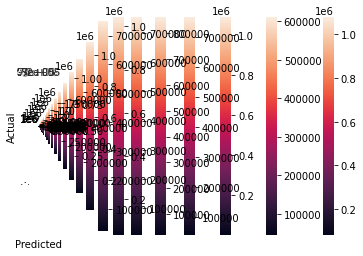

In [ ]:
#UnderSampling
output =[]
for c in code:
    try:
        summaryy=getlogitSummarySampling(c,RandomUnderSampler())
    except:
        pass
    output.append('a:'+':'.join([':'.join([a for a in b.replace(' ',',').split(',') if a ]) for b in summaryy.split('\n')[2:4]]))
print(output)

In [ ]:
output

['a:0:0.88:0.93:0.90:1160523:1:0.58:0.44:0.50:259157', 'a:0:0.92:0.45:0.61:1118667:1:0.30:0.85:0.44:301013', 'a:0:1.00:0.85:0.92:1284013:1:0.41:0.98:0.58:135667', 'a:0:0.95:0.58:0.72:1327064:1:0.08:0.54:0.14:92616', 'a:0:0.98:0.64:0.77:1341958:1:0.11:0.74:0.19:77722', 'a:0:0.99:0.45:0.62:1366115:1:0.06:0.83:0.10:53565', 'a:0:0.95:0.78:0.86:1331856:1:0.11:0.40:0.17:87824', 'a:0:0.96:0.40:0.57:1257727:1:0.16:0.86:0.26:161953', 'a:0:1.00:0.77:0.87:1399927:1:0.04:0.74:0.08:19753', 'a:0:0.98:0.58:0.73:1356954:1:0.07:0.70:0.13:62726', 'a:0:0.99:0.77:0.86:1380443:1:0.08:0.69:0.14:39237', 'a:0:0.99:0.54:0.70:1352739:1:0.08:0.86:0.15:66941', 'a:0:1.00:0.63:0.77:1414132:1:0.00:0.46:0.01:5548', 'a:0:1.00:0.77:0.87:1416179:1:0.01:0.91:0.02:3501', 'a:0:1.00:0.83:0.91:1409244:1:0.02:0.58:0.05:10436', 'a:0:1.00:0.75:0.86:1409959:1:0.02:0.64:0.03:9721', 'a:0:1.00:0.78:0.88:1407149:1:0.04:0.99:0.07:12531', 'a:0:1.00:0.77:0.87:1416999:1:0.01:0.98:0.02:2681', 'a:0:1.00:0.67:0.80:1414546:1:0.01:0.51:0.01:

['BATTERY',
 'THEFT',
 'NARCOTICS',
 'ASSAULT',
 'BURGLARY',
 'ROBBERY',
 'OTHER OFFENSE',
 'CRIMINAL DAMAGE',
 'WEAPONS VIOLATION',
 'DECEPTIVE PRACTICE',
 'CRIMINAL TRESPASS',
 'MOTOR VEHICLE THEFT',
 'SEX OFFENSE',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'OFFENSE INVOLVING CHILDREN',
 'PUBLIC PEACE VIOLATION',
 'PROSTITUTION',
 'GAMBLING',
 'CRIM SEXUAL ASSAULT',
 'LIQUOR LAW VIOLATION',
 'ARSON',
 'STALKING',
 'KIDNAPPING',
 'INTIMIDATION',
 'CONCEALED CARRY LICENSE VIOLATION',
 'NON - CRIMINAL',
 'HUMAN TRAFFICKING',
 'OBSCENITY',
 'CRIMINAL SEXUAL ASSAULT',
 'PUBLIC INDECENCY',
 'OTHER NARCOTIC VIOLATION',
 'NON-CRIMINAL',
 'HOMICIDE',
 'NON-CRIMINAL (SUBJECT SPECIFIED)',
 'RITUALISM',
 'Primary Type',
 'Primary Type']

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

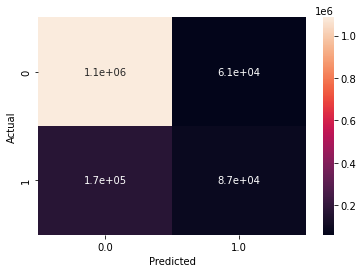

In [ ]:
# Generate a confusion matrix for our model.
confusion_matrix = pd.crosstab(y_test, np.round_(logit.predict(x_test), 0), rownames = ['Actual'], colnames = ['Predicted'])
sns.heatmap(confusion_matrix, annot = True)

In [ ]:
# Generate a classification report for our model.
print(classification_report(y_test, np.round_(logit.predict(x_test), 0)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90   1147228
           1       0.59      0.34      0.43    258223

    accuracy                           0.83   1405451
   macro avg       0.72      0.64      0.67   1405451
weighted avg       0.81      0.83      0.82   1405451



In [ ]:
[print(outpu) for outpu in output]